In [0]:
import pystan
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
import seaborn
import io 
%matplotlib inline

In [4]:
from google.colab import files
upload = files.upload()

Saving weekly_in_situ_co2_mlo - weekly_in_situ_co2_mlo.csv to weekly_in_situ_co2_mlo - weekly_in_situ_co2_mlo (4).csv


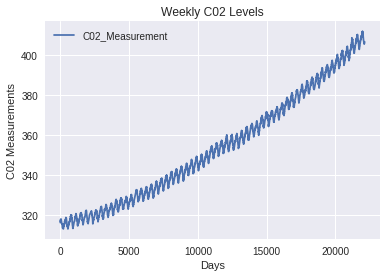

In [5]:
df = pd.read_csv(
    io.StringIO(
        upload[
            'weekly_in_situ_co2_mlo - weekly_in_situ_co2_mlo.csv'].decode(
            'utf-8')))

plt.plot(df["Days"],df["C02_Measurement"])
plt.xlabel('Days')
plt.ylabel('C02 Measurements')
plt.title('Weekly C02 Levels')
plt.legend()
plt.show()

Long-term trend: $quadratic:  c _{0}t^2 + c_{1}t+c_{2}$

Seasonal variation (every 365 $\frac{1}{4}$ days): $cosine: c_{3}  cos \frac{2πt}{365.25}+ c_{4}$

Noise: Gaussian with 0 mean and fixed standard deviation, $c_{5}$

The $c_{i}$ variables are all unobserved parameters of the model.

Combining these three components gives the following likelihood function

$P(x | θ) = N(c_{0}t^2 + c_{1}t+c_{2} +  c_{3}  cos \frac{2πt}{365.25}+ c_{4}),c^2_{5} )$

In [0]:
n_future = 2080  #40 years in weeks
n = 3091 #number of data points (no of weeks data has been collected)
data = df["C02_Measurement"]  #C02 measurements
days = df["Days"]

In [21]:
# The Stan model. Running this cell compiles the Stan model, which takes
# some time.

stan_data = {
    'n': n,
    'n_future': n_future,
    'x': data[:n]}

stan_code = """
data {
    int<lower=0> n;        // The number of data
    real x[n];             // The data
    int<lower=0> n_future; // The number of future values to predict
}

parameters {
    real<lower=0> c0;   
    real<lower=0> c1;
    real<lower=0> c2;  
    real<lower=0> c3;  //amplitude
    real<lower=0, upper=2*pi()> c4; //phase shift
    real<lower=0> c5; //noise
}

model {
    c0 ~ normal(-15, 5); 
    c1 ~ normal(0, 1);
    c2 ~ normal(6, 1);
    c3 ~ normal(1, 0.5);  
    c4 ~ normal(1, 2);
    c5 ~ normal(0, 1);  //using a  gama (1,1) proved to be taking long so I improvised
    for(t in 1:n) {
        x[t] ~ normal(c0*t^2 + c1*t + c2 + c3*cos((2*t*pi())/365 + c4), c5);
    }
}

// Generate the predicted function values for the next n_future steps.
generated quantities {
    real x_future[n_future];
    for(t in 1:n_future) {
        x_future[t] = normal_rng(
        c0*(t+n)^2 + c1*(t+n) + c2 + c3*cos((2*(t+n)*pi())/365 + c4), c5);
    }
}
"""

stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_291f646a57cd6eb0fcfc6d43e2daa684 NOW.
/usr/local/lib/python3.6/dist-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmptz8k20e_/stanfit4anon_model_291f646a57cd6eb0fcfc6d43e2daa684_4448326800595631063.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [22]:
# Run Hamiltonian Monte Carlo using Stan with 4 Markov chains, a 1000 step
# warm-up phase and 1000 step sampling phase for each chain. The warm-up samples
# are discarded, so we are left with 4 x 1000 = 4000 samples.

# This cell will take a minute or two to run.

parameters = ['c0','c1','c2','c3','c4','c5']

results = stan_model.sampling(data=stan_data)
print(results.stansummary(pars=parameters))
samples = results.extract()

Inference for Stan model: anon_model_291f646a57cd6eb0fcfc6d43e2daa684.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
c0 1.9e-8 3.0e-10 1.9e-84.3e-10 5.4e-9 1.3e-8 2.6e-8 7.2e-8   3826    1.0
c1   0.16  2.0e-5 9.1e-4   0.16   0.16   0.16   0.16   0.16   2163    1.0
c2  40.12    0.02   1.02  38.04  39.44  40.11  40.79  42.19   1906    1.0
c3   1.07    0.01   0.51   0.14   0.71   1.07   1.42   2.11   1822    1.0
c4   3.26    0.05   1.53   0.12    2.3    3.7    4.4   5.42    956    1.0
c5  77.78  9.2e-3   0.48  76.84  77.46  77.77  78.09  78.74   2730    1.0

Samples were drawn using NUTS at Fri Dec 21 21:37:40 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


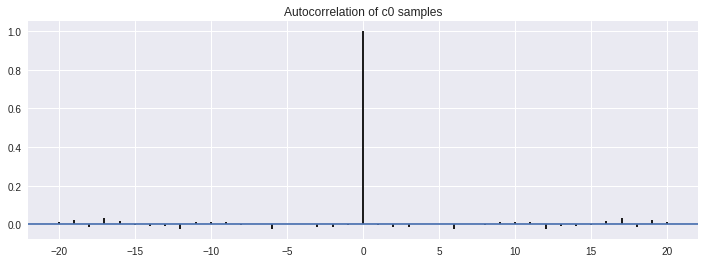

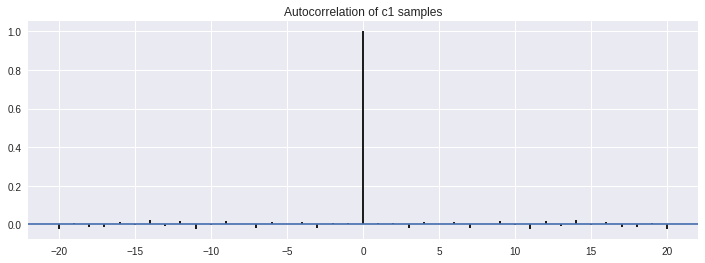

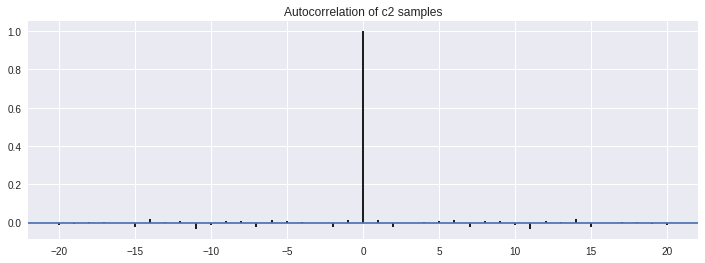

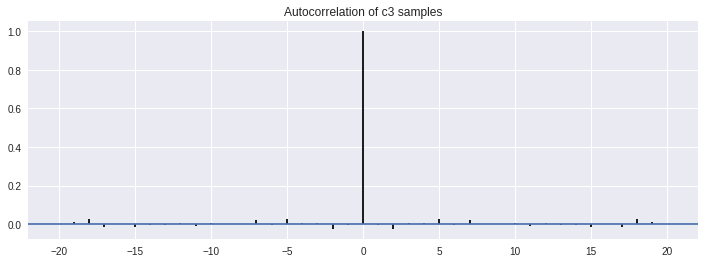

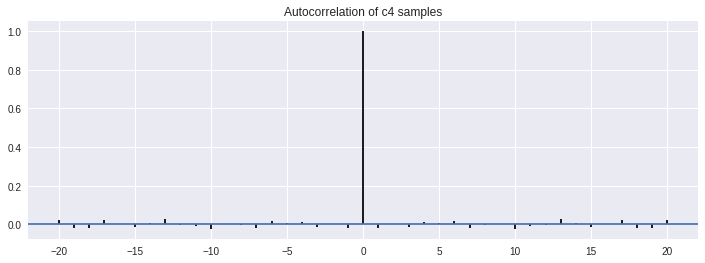

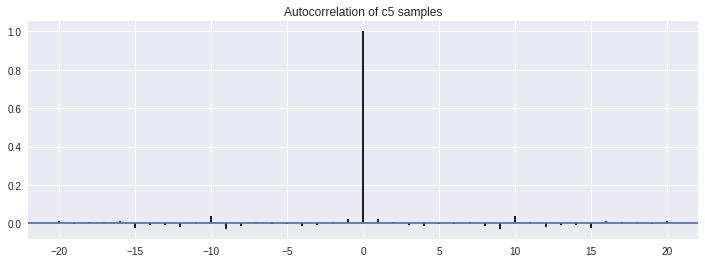

In [23]:
def plot_acf(x):
    '''
    Plot the autocorrelation function for a series x. This corresponds to the
    acf() function in R. The series x is detrended by subtracting the mean of
    the series before computing the autocorrelation.
    '''
    from scipy import signal
    plt.acorr(
        x, maxlags=20, detrend=lambda x: signal.detrend(x, type='constant'))


for param in parameters:
    plt.figure(figsize=(12, 4))
    plot_acf(samples[param])
    plt.title(f'Autocorrelation of {param} samples')

plt.show()

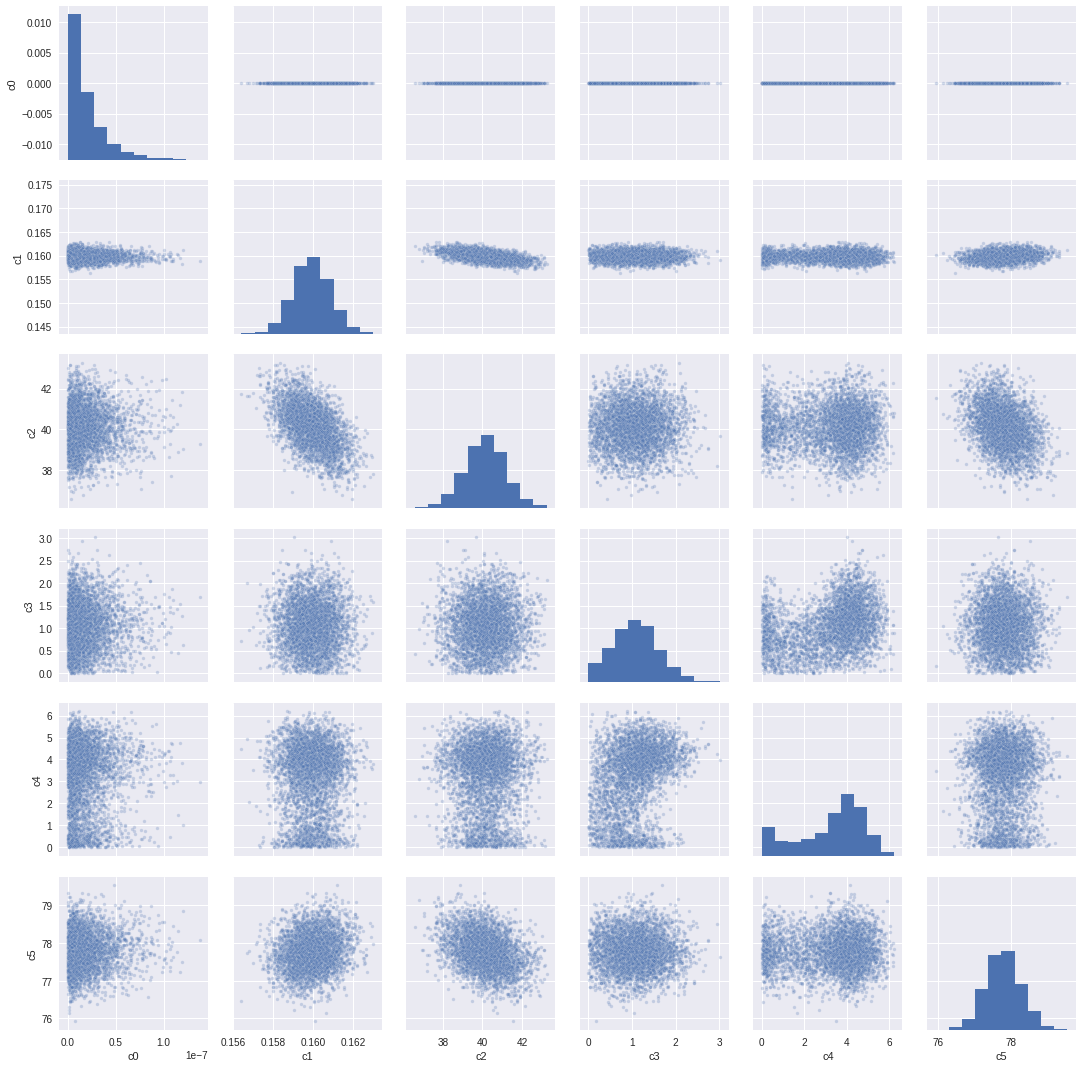

In [24]:
df2 = pd.DataFrame(
    data=np.transpose([samples[param] for param in parameters]),
    columns=parameters)
seaborn.pairplot(df2, size=2.5, plot_kws={'marker': '.', 'alpha': 0.25})
plt.show()

In [15]:
prediction = samples['x_future']

# Compute 95% interval of the predicted values
prediction_interval = np.percentile(prediction, axis=0, q=[2.5, 50, 97.5])
print(len(prediction_interval[0]))
print(len(days))

2080
3091


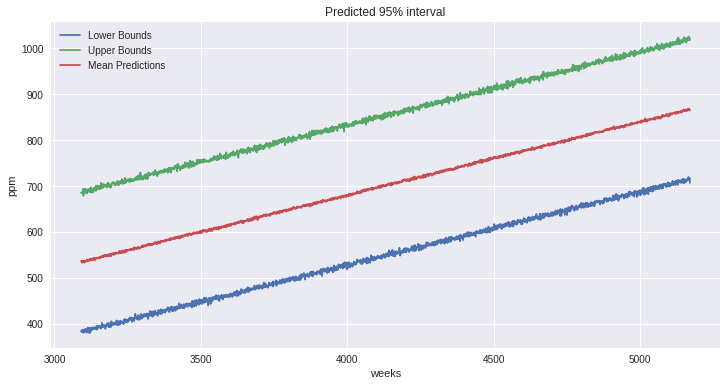

In [27]:
# Plot mean and 95% interval of predictions
plt.figure(figsize=(12, 6))
plt.plot(range(n, n + n_future),prediction_interval[0], label='Lower Bounds')
plt.plot(range(n, n + n_future),prediction_interval[2], label='Upper Bounds')
plt.plot(range(n, n + n_future),prediction_interval[1], label='Mean Predictions')
plt.xlabel('weeks')
plt.ylabel('ppm')
plt.legend()
plt.title('Predicted 95% interval')
plt.show()